In [45]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [50]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address, timeout = 10000)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [2]:
url = "https://cocl.us/new_york_dataset"
response = requests.get(url).json()
    
# all data is present in features label
features = response["features"]
    
# define the dataframe columns
column_names = ["Borough", "Neighborhood", "Latitude", "Longitude"] 

# instantiate the dataframe
ny_data = pd.DataFrame(columns=column_names)
    
for data in features:
    borough = data["properties"]["borough"] 
    neighborhood_name = data["properties"]["name"]
        
    neighborhood_latlon = data["geometry"]["coordinates"]
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_data = ny_data.append({"Borough": borough,
                                "Neighborhood": neighborhood_name,
                                "Latitude": neighborhood_lat,
                                "Longitude": neighborhood_lon}, ignore_index=True)

In [3]:
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [16]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
        
    CLIENT_ID = 'IFJ1XKUYSTZVAHX3EY3DVBDR2DMYWUZLZOXW3FRS22CKNUUB' # your Foursquare ID
    CLIENT_SECRET = 'QPTQNQJQKKMIM2XYW0TAKWHVWCZZVAOYECLMSMV5EK4AU2ET' # your Foursquare Secret
    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

In [17]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'IFJ1XKUYSTZVAHX3EY3DVBDR2DMYWUZLZOXW3FRS22CKNUUB' # your Foursquare ID
    CLIENT_SECRET = 'QPTQNQJQKKMIM2XYW0TAKWHVWCZZVAOYECLMSMV5EK4AU2ET' # your Foursquare Secret
    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


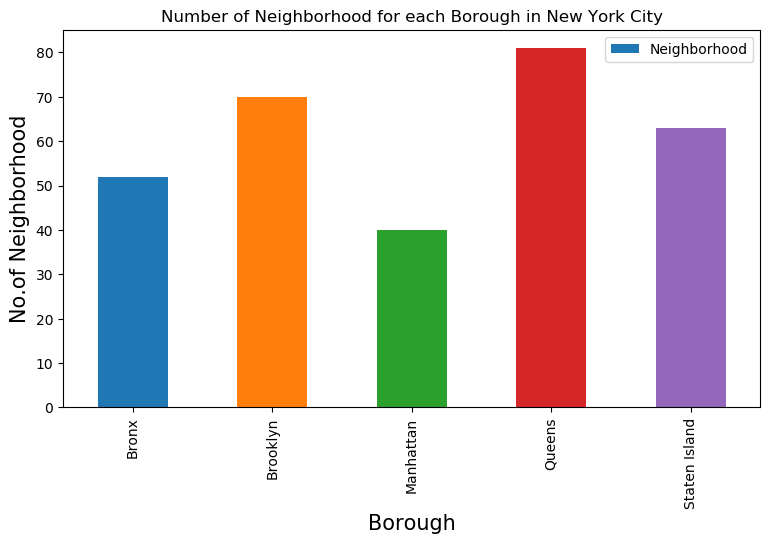

In [6]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
ny_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [7]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:1
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:2
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [8]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [9]:
indian_rest_ny.shape

(145, 4)

#### We got 145 Indian Resturants across New York City

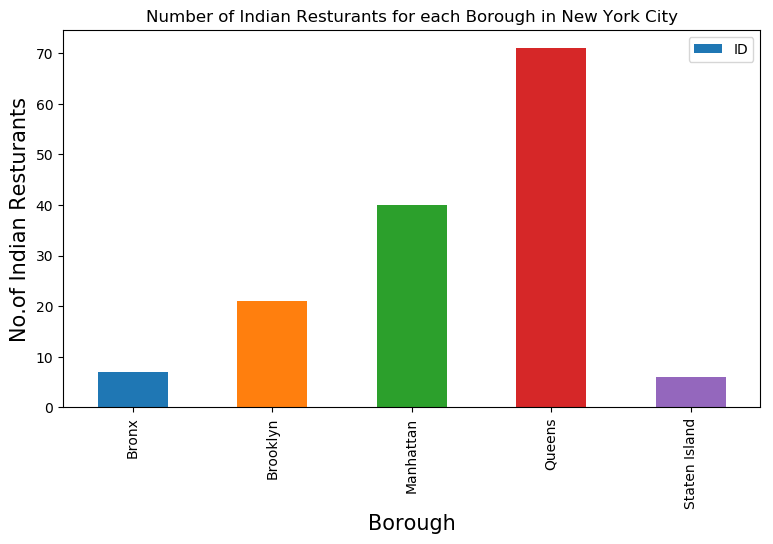

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### We see that Queens has the largest number of indian resturants 

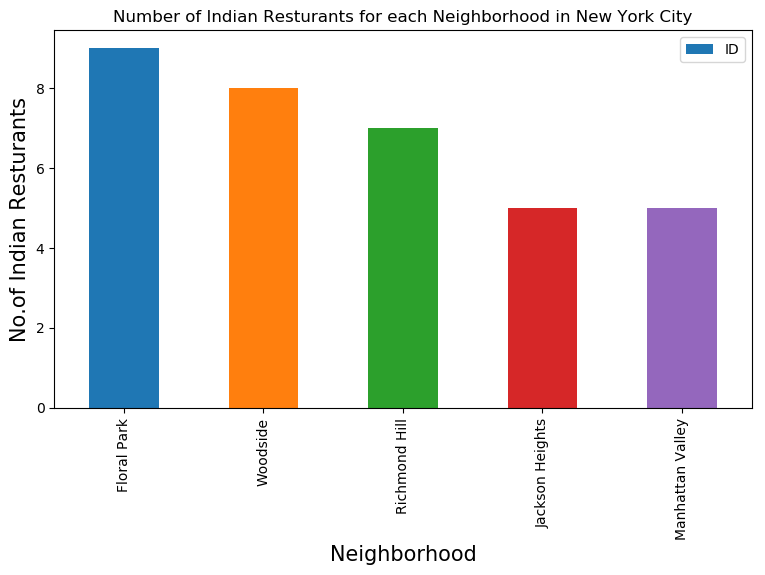

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [12]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
98,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
99,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
100,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
101,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
102,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
103,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
104,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
105,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
106,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


#### So Floral Park in Queens has the highest number of Indian Resturants with a total count of 9. Now we will get the ranking of each resturant for further analysis.

In [18]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     8.0    10
( 1 / 145 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 2 / 145 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 3 / 145 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.7     3
( 4 / 145 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 5 / 145 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 6 / 145 ) processed
                         ID       Name  Likes  Rat

                         ID      Name  Likes  Rating  Tips
0  4c7060e734443704ca0e245f  Kababish     30     7.9    17
( 54 / 145 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4b998d3ff964a520fc8235e3  Maharaja Sweets & Snacks     52     8.2    25
( 55 / 145 ) processed
                         ID                     Name  Likes  Rating  Tips
0  5da4fbf091a08400078be19d  Angel Indian Restaurant     10     8.2     1
( 56 / 145 ) processed
                         ID  Name  Likes  Rating  Tips
0  4b189424f964a52043d423e3  Dera     48     7.5    19
( 57 / 145 ) processed
                         ID           Name  Likes  Rating  Tips
0  49ebb18ff964a52016671fe3  Delhi Heights     34     7.8    24
( 58 / 145 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4e334b7bb0fb17f64f81a8b2  Premium Sweets & Restaurant     11     7.5     6
( 59 / 145 ) processed
                         ID           Name  Likes  R

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e6bfe1c7d8b2c711b17bbe5
( 107 / 145 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4f580c1be4b0bdfd0e7e8102  Rajdhani Indian Restaurant     13     8.4     6
( 108 / 145 ) processed
                         ID              Name  Likes  Rating  Tips
0  4c434b2bd691c9b6ef8f8f0a  Sagar Restaurant     10     7.3     6
( 109 / 145 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b8d5734f964a520b1f532e3
( 110 / 145 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c66f1ac8e9120a1b266d964
( 111 / 145 ) processed
                         ID                  Name  Likes  Rating  Tips
0  5623f6f9498e5a44a08bfae8  Boishakhi Restaurant     17     7.9     7
( 112 / 145 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No da

In [19]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [20]:
indian_rest_stats_ny.shape

(145, 7)

#### So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [21]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [22]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [23]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
Borough         145 non-null object
Neighborhood    145 non-null object
ID              145 non-null object
Name            145 non-null object
Likes           145 non-null object
Rating          145 non-null float64
Tips            145 non-null object
dtypes: float64(1), object(6)
memory usage: 8.0+ KB


In [24]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [25]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [26]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
Borough         145 non-null object
Neighborhood    145 non-null object
ID              145 non-null object
Name            145 non-null object
Likes           145 non-null float64
Rating          145 non-null float64
Tips            145 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.0+ KB


In [27]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 38, dtype: object

In [28]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 38, dtype: object

In [29]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a70a75bf964a52016d81fe3
Name                 Bhatti Indian Grill
Likes                                422
Rating                               8.7
Tips                                 160
Name: 47, dtype: object

#### Now lets visualize neighborhood with maximum average rating of resturants

In [30]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [31]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
64,Tribeca,9.1
60,Sunnyside,9.1
5,Blissville,9.1
12,Civic Center,9.1
70,West Village,8.8
42,Murray Hill,8.8
23,Fort Greene,8.7
40,Midtown South,8.7
27,Gramercy,8.7
11,Chelsea,8.7


#### Above are the top neighborhoods with top average rating of Indian resturants

In [32]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [33]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.217500
1,Brooklyn,7.680952
3,Queens,6.546479
0,Bronx,5.700000
4,Staten Island,5.300000


#### Similarly these are the average rating of Indian Resturants for each Borough. Let's visualize it. 

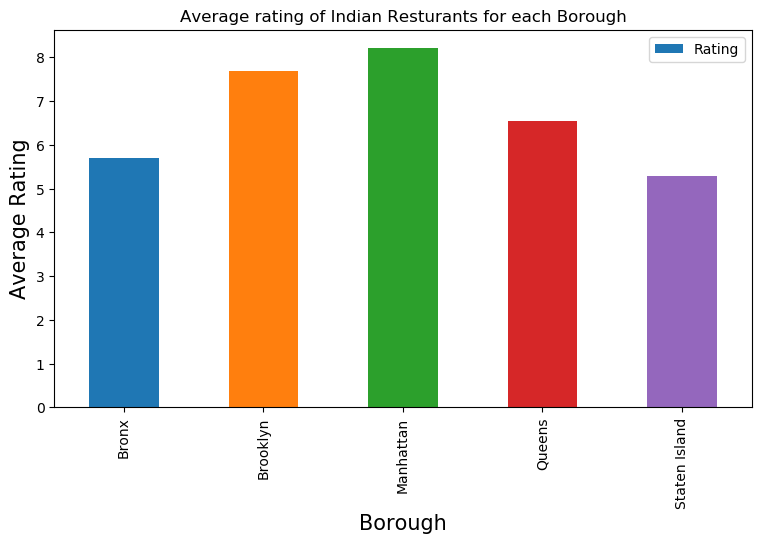

In [34]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map. 

In [35]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [36]:
ny_neighborhood_stats

,Neighborhood,Average Rating
5,Blissville,9.1
12,Civic Center,9.1
60,Sunnyside,9.1
64,Tribeca,9.1


#### We will join this dataset to original new york data to get lonitude and latitude.

In [38]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')

In [39]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [40]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Blissville,40.737251,-73.932442,9.1
1,Manhattan,Civic Center,40.715229,-74.005415,9.1
2,Queens,Sunnyside,40.740176,-73.926916,9.1
3,Staten Island,Sunnyside,40.612760,-74.097126,9.1
4,Manhattan,Tribeca,40.721522,-74.010683,9.1


#### Now we will show this data on a map.

In [51]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [52]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


#### Let's add a new field to dataframe for labeling purpose.

In [53]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [54]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)